# Lumoshive Data Science Final Project

### Basic Configurations

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import math
import seaborn as sns
import re

## SKlearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report,precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.calibration import LabelEncoder

In [3]:
df_tr = pd.read_csv("transactions_mix.csv")
df_sb = pd.read_csv("subscriptions_mix.csv")
pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",100)

/var/folders/yg/gk3kh2hn45gb3sb4nslzjfy00000gn/T/ipykernel_5566/312146456.py:1: DtypeWarning: Columns (4,6,10,13,14,15,16,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tr = pd.read_csv("transactions_mix.csv")
/var/folders/yg/gk3kh2hn45gb3sb4nslzjfy00000gn/T/ipykernel_5566/312146456.py:2: DtypeWarning: Columns (4,6,10,13,16,18,20,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sb = pd.read_csv("subscriptions_mix.csv")


In [4]:
df_tr

,id,created_at,country,operator,service,source,msisdn,event,event_date,cycle,revenue,currency,charge_date,publisher,handset,browser,trxid,telco_api_url,telco_api_response,sms_content,status_sms
0,1,2023-09-13 16:50:38.933,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-BsR34r8YUdKfebHXSuTd/2nE1guUkOBbxCZ...,renewal,2023-08-08 00:35:39.000,daily,0:00,NaN,2023-08-08 00:35:39.000,NaN,NaN,NaN,c3c31cc6-f59c-4d3d-b50d-82b1d1ad5bb0,NaN,NaN,NaN,1
1,2,2023-09-13 16:50:38.936,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-3NE20RCOX+Ec9GA6Cqs4BkgX/gAVg7I/s7y...,renewal,2023-08-08 00:00:36.000,daily,150:00:00,NaN,2023-08-08 00:00:36.000,NaN,NaN,NaN,c0c13113-f39c-4ae6-aa24-d95b5d16130b,NaN,NaN,NaN,1
2,3,2023-09-13 16:50:38.937,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-BaTa5dR4N9wsaiR2h9dS5MVkxdYjZLbqzrq...,renewal,2023-08-08 00:03:18.000,daily,150:00:00,NaN,2023-08-08 00:03:18.000,NaN,NaN,NaN,9f31aeb4-50c2-4b2b-90d3-76a8894e0dd5,NaN,NaN,NaN,1
3,4,2023-09-13 16:50:38.939,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:12.000,daily,0:00,NaN,2023-08-08 01:09:12.000,NaN,NaN,NaN,58dedf99-cfe0-4ab2-822b-4c518c85ca31,NaN,NaN,NaN,1
4,5,2023-09-13 16:50:38.944,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-YpWV5oqkXjJjzuM2fXU6K5MharguG0qWqPC...,renewal,2023-08-08 00:03:20.000,daily,150:00:00,NaN,2023-08-08 00:03:20.000,NaN,NaN,NaN,80e6922b-b479-40dd-8c5b-0a991fd8828b,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505425,46747,2023-09-13 15:45:38.791,LA,etl,slypee,cp1,2028847296,renewal,2023-08-25 14:38:28.000,daily,0,LAK,2023-08-25 14:38:28.000,lumos,NaN,No Detected,NaN,http://182.16.255.85:8093/ETLPaymentTopup/serv...,"Error MSG: ABM fee not enough, Freeze fee failed!",NaN,NaN
505426,46735,2023-09-13 15:45:38.790,LA,etl,slypee,cp1,2029307038,renewal,2023-08-25 14:32:53.000,daily,0,LAK,2023-08-25 14:32:53.000,lumos,NaN,No Detected,NaN,http://182.16.255.85:8093/ETLPaymentTopup/serv...,"Error MSG: ABM fee not enough, Freeze fee failed!",NaN,NaN
505427,46751,2023-09-13 15:45:38.795,LA,etl,slypee,cp1,2022909035,first_charge,2023-08-25 12:41:05.000,daily,2000,LAK,2023-08-25 12:41:05.000,lumos,NaN,No Detected,NaN,http://182.16.255.85:8093/ETLPaymentTopup/serv...,NaN,NaN,NaN
505428,46740,2023-09-13 15:45:38.791,LA,etl,slypee,cp1,2029315559,first_charge,2023-08-25 12:27:43.000,daily,0,LAK,2023-08-25 12:27:43.000,lumos,NaN,No Detected,NaN,http://182.16.255.85:8093/ETLPaymentTopup/serv...,"Error MSG: ABM fee not enough, Freeze fee failed!",NaN,NaN


In [5]:
df_sb

,id,created_at,country,operator,service,source,msisdn,status,cycle,adnet,revenue,subs_date,renewal_date,freemium_end_date,unsubs_from,unsubs_date,service_price,currency,profile_status,publisher,trxid,pixel,handset,browser,attempt_charging,success_billing
0,302164,2023-09-13 09:47:57.713,TH,ais,459505104,sms,66988602911,0,daily,NaN,0,2022-10-20 19:28:02.000,2023-09-14 00:00:00.000,2022-10-20 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230913070749401088.0,NaN,NaN,NaN,15,0
1,3521,2023-09-13 09:21:13.679,TH,ais,459505104,sms,66822243080,0,daily,NaN,0,2020-08-23 16:11:02.000,2023-09-14 00:00:00.000,2020-08-23 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230913070724300800.0,NaN,NaN,NaN,15,0
2,1,2023-09-13 09:20:20.727,TH,ais,459505106,ivr,666131,0,1,NaN,6,2023-08-25 14:02:05.000,2023-08-26 00:00:00.000,2023-08-25 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230825140205699072.0,NaN,NaN,NaN,1,1
3,4999335,2023-09-13 14:00:22.171,TH,ais,459505105,wap,66650020857,0,daily,star,0,2023-09-09 13:03:24.000,2023-09-14 00:00:00.000,2023-09-09 00:00:00.000,NaN,NaN,6,BATH,Active,star,20230913071052099584.0,star-APP1694223212644066,NaN,NaN,5,0
4,273196,2023-09-13 09:45:33.449,TH,ais,459505104,sms,66635959286,0,daily,NaN,0,2022-09-26 19:36:03.000,2023-09-14 00:00:00.000,2022-09-26 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230913070115598336.0,NaN,NaN,NaN,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308906,22019,2023-09-14 06:55:36.464,OM,omantel,goaly,cp1,96898097014,0,daily,kee,0,2023-05-11 09:50:11.000,2023-05-11 09:50:26.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0
308907,22037,2023-09-14 06:55:36.475,OM,omantel,goaly,cp1,96872209910,0,daily,kee,0,2023-05-11 09:49:50.000,2023-05-11 09:50:09.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0
308908,22062,2023-09-14 06:55:36.485,OM,omantel,goaly,cp1,96891448321,0,daily,kee,0,2023-05-11 06:15:24.000,2023-05-11 06:15:52.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0
308909,22083,2023-09-14 06:55:36.498,OM,omantel,goaly,cp1,96891982806,0,daily,kee,0,2023-05-11 16:44:57.000,2023-05-11 16:45:19.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0


### View Data

#### General

##### Operator

In [6]:
print("Transaction Table")
print(df_tr["operator"].unique())
print("Subscriptions Table")
print(df_sb["operator"].unique())
## TODO: Lowercase

Transaction Table
['sen-orange-mtarget' 'ais' 'omantel' 'ltc' 'etl']
Subscriptions Table
['ais' 'sen-orange-mtarget' 'etl' 'tplus' 'ltc' 'LTC' 'omantel']


##### Country Type

In [7]:
print("Transaction Table")
print(df_tr["country"].unique())
print("Subscriptions Table")
print(df_sb["country"].unique())

Transaction Table
['SN' 'TH' 'th' 'OM' 'LA']
Subscriptions Table
['TH' 'SN' 'LA' 'OM']


##### Service

In [8]:
print("Transaction Table")
print(df_tr["service"].unique())
print("Subscriptions Table")
print(df_sb["service"].unique())

## TODO: Change the datatype to varchar everything

Transaction Table
['gemezz' '459505104' '459505105' '459509903' '459505106' '459509902'
 459505104 459505106 459505105 459509902 459509901 459509903 '459509901'
 'goaly' 'halogame' 'slypee']
Subscriptions Table
[459505104 459505106 459505105 459509902 459509903 459509901 '459505105'
 '459505106' '459505104' '459509903' '459509902' '459509901' 'gemezz'
 'slypee' 'halogame' 'Halogame' 'goaly']


##### Source

In [9]:
print("Transaction Table")
print(df_tr["source"].unique())
print("Subscriptions Table")
print(df_sb["source"].unique())
## TODO: Lower case, USSD_W, mo_USSD and USSD_D can be changed to USSD

Transaction Table
[nan 'sms' 'wap' 'Sms' 'ivr' 'cp1' 'lp1' 'default' 'lp2' 'lp6' 'mo_ussd'
 'portal' 'lp7' 'mo_sms' 'USSD' 'lp3' 'SMS' 'lp4']
Subscriptions Table
['sms' 'ivr' 'wap' 'web' nan 'USSD' 'cp1' 'lp3' 'lp4' 'lp1' 'SMS'
 'mo_ussd' 'portal' 'lp6' 'mo_sms' 'lp7' 'USSD_W' 'USSD_D']


In [10]:
print("Transaction Table")
print(df_tr["cycle"].unique())
print("Subscriptions Table")
print(df_sb["cycle"].unique())
## TODO: Lower case, USSD_W, mo_USSD and USSD_D can be changed to USSD

Transaction Table
['daily' 'weekly']
Subscriptions Table
['daily' '1' 'weekly']


##### Currency

In [11]:
print("Transaction Table | Currency")
print(df_tr["currency"].unique())
print("Subscription Table | Currency")
print(df_sb["currency"].unique())

## TODO: Clean the data to lowercase data

Transaction Table | Currency
[nan 'BATH' 'Rial' 'LAK']
Subscription Table | Currency
['BATH' nan 'LAK' 'Kip' 'Rial']


#### Transaction Table

In [12]:
# print("Transaction Table | Status")
# print(df_tr["status"].unique())

# ## TODO: Clean the data to lowercase data

##### Event

In [13]:
print("Transaction Table | Event")
print(df_tr["event"].unique())

## TODO: Clean the data to lowercase data

Transaction Table | Event
['renewal' 'Renewal' 'Unsubscription' 'Subscription' 'notif@renew'
 'notif@mt' 'unsubscribe' 'renewal@cp1' 'renewal@lp6' 'renewal@mo_ussd'
 'renewal@portal' 'subscribe@lp6' 'subscribe-nb@cp1' 'renewal-nb@cp1'
 'retry@mo_ussd' 'retry@portal' 'retry@cp1' 'subscribe@portal'
 'renewal@lp7' 'renewal@mo_sms' 'retry@lp6' 'retry@lp7'
 'manual_renewal@cp1' 'first_charge']


In [14]:
## Currency cannot be imputed randomly, since the country "SN" has NaN value on currency. We can replace it CFA Franc (XOF).
df_tr['currency'].fillna("XOF", inplace=True)
## We also do not know which source does "SN" use, therefore we can fill the NaN value to Unknown
df_tr['source'].fillna("None", inplace=True)

##### Query Test

In [15]:
df_tr.query("source.isna()")

,id,created_at,country,operator,service,source,msisdn,event,event_date,cycle,revenue,currency,charge_date,publisher,handset,browser,trxid,telco_api_url,telco_api_response,sms_content,status_sms


#### Subs Table

##### Status


In [16]:
print("Transaction Table | Status")
print(df_sb["status"].unique())

## TODO: Clean the data to lowercase data

Transaction Table | Status
[ 0  1 -1  2]


##### AdNet (Subscription Table)

In [17]:
print("Subscriptions Table")
adnet = df_sb["adnet"].unique()
for ad in adnet:
    print(ad)

## TODO: Clean The data seperti APP 

Subscriptions Table
nan
star
mpl
STAR
lig
mbv
svr
btm
MBP
MOV
lig-64f232e136d2470001f66bd6
sco
soy
LIG
star-APP1693530532379629
star-APP1693446113351865
sdt
bads
ven
star-APP1693447254332150
lig-64efb52946cb830001efe853
mbvs
star-APP1693444719074085
star-APP1693359300105393
lig-64eead2f46cb83000102332d
star-APP1693531983150699
star-APP1693532242725771
mgm
star-APP1693359626944477
lig-64ee8548c5c3ad000188907f
aiscm
lig-64f159cfa161810001ba38a1
lig-64efdea196101d0001148c22
lig-64eeab7739141c0001f976b4
star-APP1693532953638844
lig-64ee91c339141c00012f6c20
star-APP1693360565438205
star-APP1693444503031790
star-APP1693446585643012
lig-64eead116ebed2000103ad0c
star-APP1693531163319920
star-APP1693532906431403
lig-64efc69c1d24f00001376f98
star-APP1693531578147204
star-APP1693532897608266
star-APP1693444038220349
star-APP1693445673015709
lig-64efa527e2e9d800010906b9
lig-64efb2ecc4ccbc000166281f
star-APP1693446114444860
star-APP1693359374274209
lig-64f1554e0e8b980001aca978
star-APP1693532554799

In [18]:
print("Subscriptions Table")
adnet = df_sb["success_billing"].unique()
for ad in adnet:
    print(ad)
## All Good

Subscriptions Table
0
1
2
15
3
11
30
4
12
5
7
8
27
10
6
22
9
14
16
13
20
28
17
23
24
25
21
18
26
19
37
38
35
34
36
29
32
31
56
33
48
61
57
41
63
62
39
50
40
47
54
43
55
42
49
53
46
44
52
59
45
64
51
58
60
66
65
101
195
71
115
154
149
68
85
122
75
220
80
120
74
83
81
214
67
76
77
69
155
87
100
112
218
72
217
79
137
142
82
196
89
90
84
93
127
213
70
168
92
96
215
86
124
208
157
211
109
105
144
130
107
203
88
117
179
133
159
132
103
73
143
163
172
78
202
164
94
200
102
177
147
128
197
194
192
106
111
146
91
95
125
98
104
162
189
193
135
108
187
145
183
181
167
97
173
119
114
158
170
129
140
141
126
121
118
116
110
113
99


In [19]:
print("Subscriptions Table")
adnet = df_sb["profile_status"].unique()
for ad in adnet:
    print(ad)

## TODO: Clean The data

Subscriptions Table
Active
Unsub
nan
inactive
active


##### Query Test

In [20]:
df_sb.query("profile_status.isna()")

,id,created_at,country,operator,service,source,msisdn,status,cycle,adnet,revenue,subs_date,renewal_date,freemium_end_date,unsubs_from,unsubs_date,service_price,currency,profile_status,publisher,trxid,pixel,handset,browser,attempt_charging,success_billing
200000,1,2023-09-13 09:19:41.923,SN,sen-orange-mtarget,gemezz,web,PDKSUB-200-++TLIxY1Z7FCcBZodmgPtQyEKOZThxNIoj9...,0,daily,NaN,0,2023-08-13 00:09:00.000,2023-08-13 00:09:00.000,NaN,sms,9999-01-01 00:00:00.000,150,NaN,NaN,NaN,dab20e86-7d36-4511-a358-c2fc4d23db42,NaN,NaN,NaN,1,0
200001,2,2023-09-13 09:19:41.924,SN,sen-orange-mtarget,gemezz,web,PDKSUB-200-++UFySDEI7FjSH+riLOrlIMUGxx1gmqBt+j...,0,daily,NaN,0,2023-08-15 03:19:00.000,2023-08-15 03:19:00.000,NaN,sms,2023-08-15 03:23:00.000,150,NaN,NaN,NaN,766b886a-5849-4d1a-89f4-9cc31147293d,NaN,NaN,NaN,2,0
200002,3,2023-09-13 09:19:41.925,SN,sen-orange-mtarget,gemezz,web,PDKSUB-200-+1tq4SA4/IQqg0YUiyiXlYS9bAAgngsW6cn...,0,daily,NaN,0,2023-08-11 19:52:00.000,2023-08-11 19:52:00.000,NaN,sms,9999-01-01 00:00:00.000,150,NaN,NaN,NaN,0175a737-9ba2-4567-b96f-16bf8bda1fc0,NaN,NaN,NaN,1,0
200003,4,2023-09-13 09:19:41.926,SN,sen-orange-mtarget,gemezz,web,PDKSUB-200-+3009QDLXvamgknPbr4DJkPQc8QV0tNb0kV...,0,daily,NaN,0,2023-08-17 10:16:00.000,2023-08-17 10:16:00.000,NaN,sms,9999-01-01 00:00:00.000,150,NaN,NaN,NaN,9c8a6da4-c7eb-4762-a582-d6100bd0af0c,NaN,NaN,NaN,1,0
200004,6,2023-09-13 09:19:41.944,SN,sen-orange-mtarget,gemezz,web,PDKSUB-200-+5u9QE/N+KrYlnJ2uraoVWsp/fjwHxzuvs7...,0,daily,NaN,0,2023-08-19 09:47:00.000,2023-08-19 09:47:00.000,NaN,sms,9999-01-01 00:00:00.000,150,NaN,NaN,NaN,527736bf-bfda-4636-91e0-baaf89d0717a,NaN,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308906,22019,2023-09-14 06:55:36.464,OM,omantel,goaly,cp1,96898097014,0,daily,kee,0,2023-05-11 09:50:11.000,2023-05-11 09:50:26.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0
308907,22037,2023-09-14 06:55:36.475,OM,omantel,goaly,cp1,96872209910,0,daily,kee,0,2023-05-11 09:49:50.000,2023-05-11 09:50:09.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0
308908,22062,2023-09-14 06:55:36.485,OM,omantel,goaly,cp1,96891448321,0,daily,kee,0,2023-05-11 06:15:24.000,2023-05-11 06:15:52.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0
308909,22083,2023-09-14 06:55:36.498,OM,omantel,goaly,cp1,96891982806,0,daily,kee,0,2023-05-11 16:44:57.000,2023-05-11 16:45:19.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0


### Data Cleaning

#### Transaction Table

In [21]:
na_count = df_tr.isna().sum()
na_count

id                         0
created_at                 0
country                    0
operator                   0
service                    0
source                     0
msisdn                     0
event                      0
event_date                 0
cycle                      0
revenue                    0
currency                   0
charge_date                0
publisher             201356
handset               244004
browser               201358
trxid                 304647
telco_api_url          14352
telco_api_response     42113
sms_content           305428
status_sms            304072
dtype: int64

In [22]:
## These columns need to be dropped since there are many NaN
cols_drop = [
    'publisher',
    'handset',
    'browser',
    'trxid',
    'telco_api_url',
    'telco_api_response',
    'sms_content',
    'status_sms'
]
df_tr.drop(cols_drop, axis=1, inplace=True)

In [23]:
## Currency cannot be imputed randomly, since the country "SN" has NaN value on currency. We can replace it CFA Franc (XOF).
df_tr['currency'].fillna("XOF", inplace=True)
## We also do not know which source does "SN" use, therefore we can fill the NaN value to Unknown
df_tr['source'].fillna("None", inplace=True)

In [24]:
##Upper and Lowercasing String
df_tr["operator"] = df_tr["operator"].astype(str).apply(lambda x : x.lower())
df_tr["source"] = df_tr["source"].astype(str).apply(lambda x : x.lower())
df_tr["service"] = df_tr["service"].astype(str).apply(lambda x : x.lower())
df_tr["country"] = df_tr["country"].astype(str).apply(lambda x : x.upper())



In [25]:
df_tr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505430 entries, 0 to 505429
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           505430 non-null  int64 
 1   created_at   505430 non-null  object
 2   country      505430 non-null  object
 3   operator     505430 non-null  object
 4   service      505430 non-null  object
 5   source       505430 non-null  object
 6   msisdn       505430 non-null  object
 7   event        505430 non-null  object
 8   event_date   505430 non-null  object
 9   cycle        505430 non-null  object
 10  revenue      505430 non-null  object
 11  currency     505430 non-null  object
 12  charge_date  505430 non-null  object
dtypes: int64(1), object(12)
memory usage: 50.1+ MB


#### Subscription Table

In [26]:
cnt_na = df_sb.isna().sum()
cnt_na

id                        0
created_at                0
country                   0
operator                  0
service                   0
source                  604
msisdn                    0
status                    0
cycle                     0
adnet                161443
revenue                   0
subs_date                 0
renewal_date              0
freemium_end_date    108911
unsubs_from          245453
unsubs_date          204626
service_price             0
currency               5721
profile_status        27397
publisher            197964
trxid                188763
pixel                219888
handset              211738
browser              208785
attempt_charging          0
success_billing           0
dtype: int64

In [27]:
## Currency cannot be imputed randomly, since the country "SN" has NaN value on currency. We can replace it CFA Franc (XOF).
df_sb['currency'].fillna("XOF", inplace=True)
## We also do not know which source does "SN" use, therefore we can fill the NaN value to Unknown / Another option that we can use impute.
df_sb['source'].fillna("None", inplace=True)
## We are going to keep the NaN value in adnet, this is one of the important variable that we need. Imputing cant be used.

## There is also a wild "1" in the cycle, we assume that is daily.
df_sb.at[2, 'cycle'] = "daily"

In [28]:
##Upper and Lowercasing String
df_sb["operator"] = df_sb["operator"].astype(str).apply(lambda x : x.lower())
df_sb["source"] = df_sb["source"].astype(str).apply(lambda x : x.lower())
df_sb["service"] = df_sb["service"].astype(str).apply(lambda x : x.lower())
df_sb["country"] = df_sb["country"].astype(str).apply(lambda x : x.upper())
df_sb["profile_status"] = df_sb["profile_status"].astype(str).apply(lambda x : x.lower())

In [29]:
## Since currency of "Kip" & "LAK" are the same. We will change Kip to Lak
df_sb["currency"] = df_sb["currency"].astype(str).apply(lambda x : "LAK" if x == "Kip" else x)

In [30]:
## Cleaning the adnet by splitting them.
df_sb["adnet"] = df_sb["adnet"].astype(str).apply(lambda x : x.split("-")[0].lower())

In [31]:
#High percentage of missing value, so we drop these columns
cols_drop = {
    'freemium_end_date',
    'unsubs_from', 
    'publisher',
    'trxid',
    'pixel',
    'handset',
    'browser',
}

df_sb.drop(cols_drop, axis=1, inplace=True)

In [32]:
#Splitting the date to day, month, year
df_sb['subs_date'] = df_sb['subs_date'].astype(str)
df_sb['subs_date'] = df_sb['subs_date'].str.split().str[0]

In [33]:
df_sb['renewal_date'] = df_sb['renewal_date'].astype(str)
df_sb['renewal_date'] = df_sb['renewal_date'].str.split().str[0]

In [34]:
df_sb['unsubs_date'] = df_sb['unsubs_date'].astype(str)
df_sb['unsubs_date'] = df_sb['unsubs_date'].str.split().str[0]

In [35]:
df_sb['subs_date'] = pd.to_datetime(df_sb['subs_date'])
df_sb['renewal_date'] = pd.to_datetime(df_sb['renewal_date'], errors='coerce')
df_sb['unsubs_date'] = pd.to_datetime(df_sb['unsubs_date'], errors='coerce') ## This will also remove the date and time that is illogical such as 0001-01-01

In [36]:
df_sb["Renew_Year"] = df_sb["renewal_date"].dt.year
df_sb["Renew_Month"] = df_sb["renewal_date"].dt.month

df_sb["Subs_Year"] = df_sb["subs_date"].dt.year
df_sb["Subs_Month"] = df_sb["subs_date"].dt.month

df_sb["Unsubs_Year"] = df_sb["unsubs_date"].dt.year
df_sb["Unsubs_Month"] = df_sb["unsubs_date"].dt.month

In [37]:
df_sb.sort_values(by = ["Subs_Year"])


,id,created_at,country,operator,service,source,msisdn,status,cycle,adnet,revenue,subs_date,renewal_date,unsubs_date,service_price,currency,profile_status,attempt_charging,success_billing,Renew_Year,Renew_Month,Subs_Year,Subs_Month,Unsubs_Year,Unsubs_Month
193155,713,2023-09-13 09:21:04.983,TH,ais,459505105,sms,66613275490,0,daily,nan,0,2020-05-30,2023-09-14,NaT,6,BATH,active,15,0,2023.0,9.0,2020,5,NaN,NaN
193365,3965,2023-09-13 09:21:16.348,TH,ais,459505105,sms,66616197404,0,daily,nan,6,2020-10-31,2023-09-14,NaT,6,BATH,active,15,1,2023.0,9.0,2020,10,NaN,NaN
193438,1993,2023-09-13 09:21:08.325,TH,ais,459505105,sms,66983531512,0,daily,nan,0,2020-06-26,2023-09-14,NaT,6,BATH,active,15,0,2023.0,9.0,2020,6,NaN,NaN
2855,2525,2023-09-13 09:21:09.701,TH,ais,459505105,sms,66610839110,0,daily,nan,0,2020-07-22,2023-09-14,NaT,6,BATH,active,15,0,2023.0,9.0,2020,7,NaN,NaN
2805,3389,2023-09-13 09:21:13.215,TH,ais,459505104,sms,66937452814,0,daily,nan,0,2020-08-19,2023-09-14,NaT,6,BATH,active,15,0,2023.0,9.0,2020,8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308908,22062,2023-09-14 06:55:36.485,OM,omantel,goaly,cp1,96891448321,0,daily,kee,0,2023-05-11,2023-05-11,NaT,300,Rial,nan,1,0,2023.0,5.0,2023,5,NaN,NaN
308909,22083,2023-09-14 06:55:36.498,OM,omantel,goaly,cp1,96891982806,0,daily,kee,0,2023-05-11,2023-05-11,NaT,300,Rial,nan,1,0,2023.0,5.0,2023,5,NaN,NaN
308910,22096,2023-09-14 06:55:36.505,OM,omantel,goaly,cp1,96899008766,0,daily,kee,0,2023-05-11,2023-05-11,NaT,300,Rial,nan,1,0,2023.0,5.0,2023,5,NaN,NaN
308889,21687,2023-09-14 06:55:36.288,OM,omantel,goaly,cp1,96892664557,1,daily,fmd,1500,2023-05-08,2023-05-12,NaT,300,Rial,nan,5,5,2023.0,5.0,2023,5,NaN,NaN


In [38]:
df_merge = df_tr.merge(df_sb, how='inner', on=('msisdn', 'msisdn'))

In [39]:
# df_merge.drop('id_y', axis=1,inplace=True)


In [40]:
# for col in df_merge.columns:
#     if col.endswith('_x'):
#         newName = col.replace('_x','_tr')
#         df_merge.rename(columns={col: newName}, inplace=True)
#     elif col.endswith('_y'):
#         newName = col.replace('_y','_subs')
#         df_merge.rename(columns={col: newName}, inplace=True)


In [41]:
df_merge

,id_x,created_at_x,country_x,operator_x,service_x,source_x,msisdn,event,event_date,cycle_x,revenue_x,currency_x,charge_date,id_y,created_at_y,country_y,operator_y,service_y,source_y,status,cycle_y,adnet,revenue_y,subs_date,renewal_date,unsubs_date,service_price,currency_y,profile_status,attempt_charging,success_billing,Renew_Year,Renew_Month,Subs_Year,Subs_Month,Unsubs_Year,Unsubs_Month
0,1,2023-09-13 16:50:38.933,SN,sen-orange-mtarget,gemezz,none,PDKSUB-200-BsR34r8YUdKfebHXSuTd/2nE1guUkOBbxCZ...,renewal,2023-08-08 00:35:39.000,daily,0:00,XOF,2023-08-08 00:35:39.000,1436,2023-09-13 09:20:07.163,SN,sen-orange-mtarget,gemezz,web,0,daily,nan,0,2023-08-08,2023-08-08,NaT,150,XOF,nan,2,0,2023.0,8.0,2023,8,NaN,NaN
1,2,2023-09-13 16:50:38.936,SN,sen-orange-mtarget,gemezz,none,PDKSUB-200-3NE20RCOX+Ec9GA6Cqs4BkgX/gAVg7I/s7y...,renewal,2023-08-08 00:00:36.000,daily,150:00:00,XOF,2023-08-08 00:00:36.000,588,2023-09-13 09:20:02.297,SN,sen-orange-mtarget,gemezz,none,-1,daily,nan,0:00,2023-09-01,2023-08-08,2023-09-01,150,XOF,nan,1,0,2023.0,8.0,2023,9,2023.0,9.0
2,3,2023-09-13 16:50:38.937,SN,sen-orange-mtarget,gemezz,none,PDKSUB-200-BaTa5dR4N9wsaiR2h9dS5MVkxdYjZLbqzrq...,renewal,2023-08-08 00:03:18.000,daily,150:00:00,XOF,2023-08-08 00:03:18.000,1228,2023-09-13 09:20:06.775,SN,sen-orange-mtarget,gemezz,web,1,daily,nan,150,2023-07-29,2023-08-11,NaT,150,XOF,nan,5,1,2023.0,8.0,2023,7,NaN,NaN
3,4,2023-09-13 16:50:38.939,SN,sen-orange-mtarget,gemezz,none,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:12.000,daily,0:00,XOF,2023-08-08 01:09:12.000,4618,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,daily,nan,0,2023-08-08,2023-08-08,2023-08-14,150,XOF,nan,4,0,2023.0,8.0,2023,8,2023.0,8.0
4,55,2023-09-13 16:50:38.998,SN,sen-orange-mtarget,gemezz,none,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:06.000,daily,0:00,XOF,2023-08-08 01:09:06.000,4618,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,daily,nan,0,2023-08-08,2023-08-08,2023-08-14,150,XOF,nan,4,0,2023.0,8.0,2023,8,2023.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401321,28005,2023-09-13 15:45:28.764,LA,etl,slypee,cp1,2022028975,renewal,2023-09-08 00:28:32.000,daily,0,LAK,2023-09-08 00:28:32.000,10916,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,daily,marvel,20000,2023-09-02,2023-09-13,2023-09-13,2000:00:00,LAK,inactive,11,10,2023.0,9.0,2023,9,2023.0,9.0
401322,31517,2023-09-13 15:45:30.909,LA,etl,slypee,cp1,2022028975,renewal,2023-09-09 00:25:55.000,daily,2000,LAK,2023-09-09 00:25:55.000,10916,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,daily,marvel,20000,2023-09-02,2023-09-13,2023-09-13,2000:00:00,LAK,inactive,11,10,2023.0,9.0,2023,9,2023.0,9.0
401323,35154,2023-09-13 15:45:32.811,LA,etl,slypee,cp1,2022028975,renewal,2023-09-10 00:26:13.000,daily,2000,LAK,2023-09-10 00:26:13.000,10916,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,daily,marvel,20000,2023-09-02,2023-09-13,2023-09-13,2000:00:00,LAK,inactive,11,10,2023.0,9.0,2023,9,2023.0,9.0
401324,38860,2023-09-13 15:45:34.717,LA,etl,slypee,cp1,2022028975,renewal,2023-09-11 00:26:39.000,daily,2000,LAK,2023-09-11 00:26:39.000,10916,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,daily,marvel,20000,2023-09-02,2023-09-13,2023-09-13,2000:00:00,LAK,inactive,11,10,2023.0,9.0,2023,9,2023.0,9.0


### Data Visualization

##### Non-Merged Data

/var/folders/yg/gk3kh2hn45gb3sb4nslzjfy00000gn/T/ipykernel_5566/985815318.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sb, x='country', palette='hsv', order=df_sb['country'].value_counts().index)


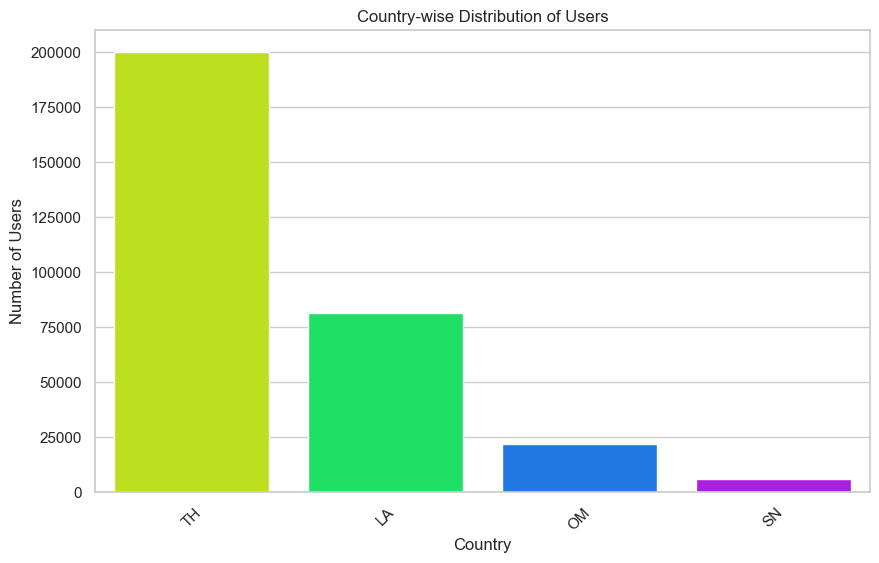

In [42]:
# Setting the visualization style
sns.set(style="whitegrid")

# Country-wise Distribution Visualization using cleaned subscriptions data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='country', palette='hsv', order=df_sb['country'].value_counts().index)
plt.title('Country-wise Distribution of Users')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()


/var/folders/yg/gk3kh2hn45gb3sb4nslzjfy00000gn/T/ipykernel_5566/1525026309.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sb, x='operator', palette='hsv', order=df_sb['operator'].value_counts().index)


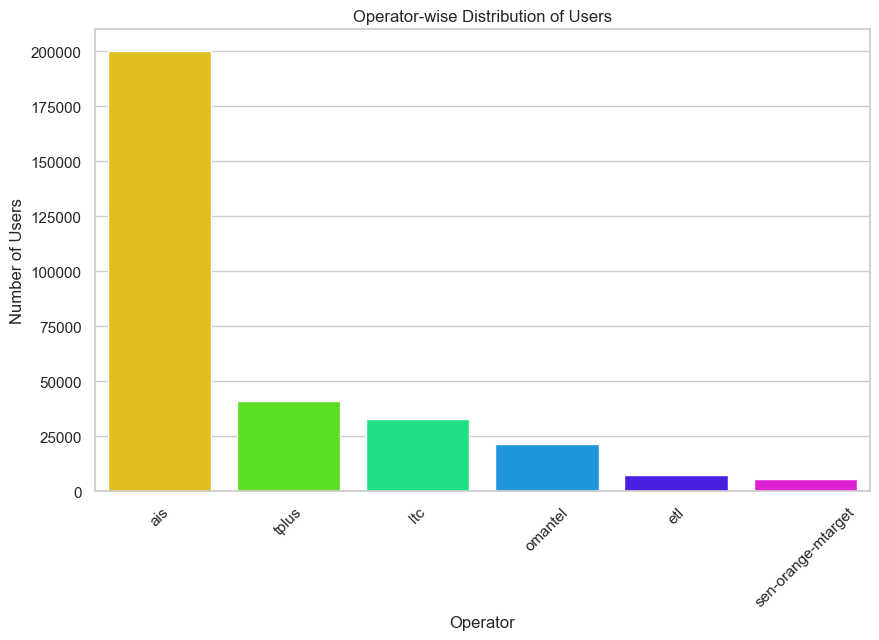

In [43]:
# Operator-wise Distribution Visualization using cleaned subscriptions data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='operator', palette='hsv', order=df_sb['operator'].value_counts().index)
plt.title('Operator-wise Distribution of Users')
plt.xlabel('Operator')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()


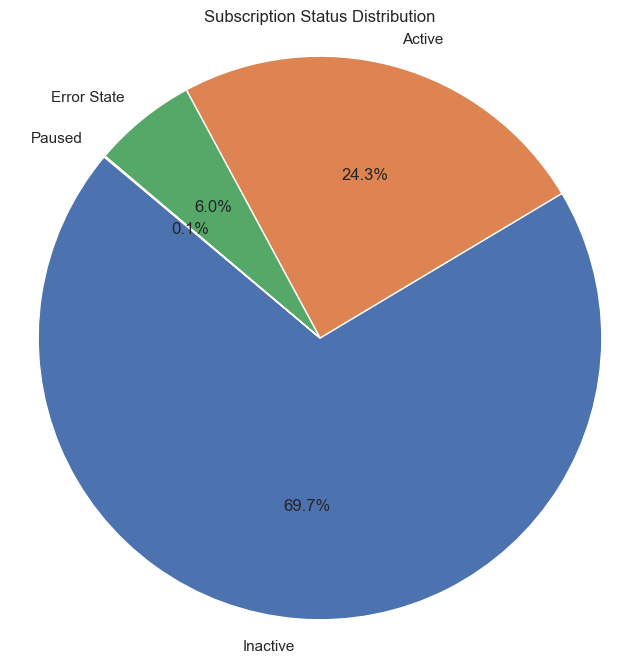

In [44]:

# Assuming df_sb is your cleaned subscriptions dataframe and has been defined earlier in your notebook.

# Define the status meanings
status_meanings = {
    -1: 'Error State',
    0: 'Inactive',  # Replace with the actual meaning
    1: 'Active',    # Replace with the actual meaning
    2: 'Paused'     # Replace with the actual meaning
}

# Map the status codes to meanings
df_sb['status_label'] = df_sb['status'].map(status_meanings)

# Subscription Status Visualization: Pie Chart
status_counts = df_sb['status_label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Subscription Status Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


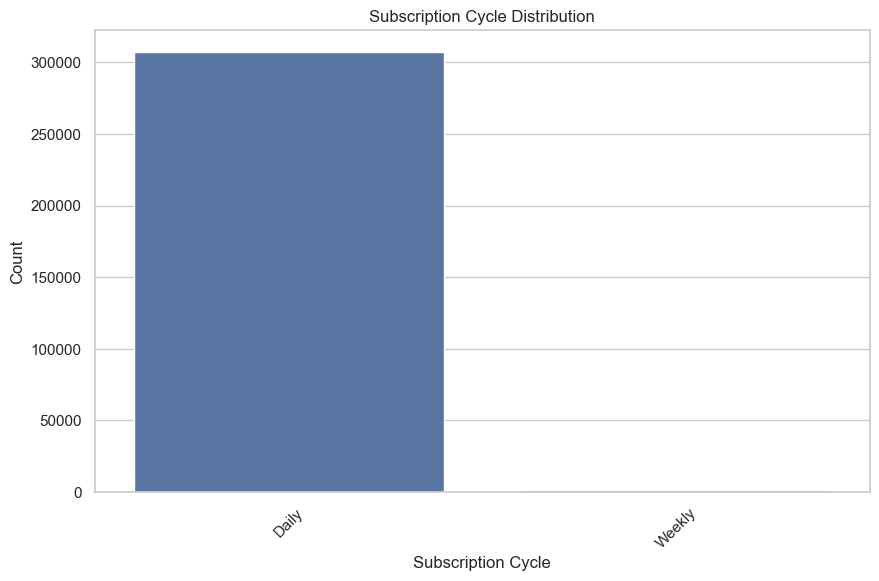

In [45]:
cycle_meanings = {
    'daily': 'Daily',
    'weekly': 'Weekly',
    'monthly': 'Monthly',
    # ... add other cycles as necessary
}

# Map the cycle codes to meanings
df_sb['cycle_label'] = df_sb['cycle'].map(cycle_meanings)

# Subscription Cycle Visualization: Bar Chart
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='cycle_label', order=df_sb['cycle_label'].value_counts().index)
plt.title('Subscription Cycle Distribution')
plt.xlabel('Subscription Cycle')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [46]:
df_sb

,id,created_at,country,operator,service,source,msisdn,status,cycle,adnet,revenue,subs_date,renewal_date,unsubs_date,service_price,currency,profile_status,attempt_charging,success_billing,Renew_Year,Renew_Month,Subs_Year,Subs_Month,Unsubs_Year,Unsubs_Month,status_label,cycle_label
0,302164,2023-09-13 09:47:57.713,TH,ais,459505104,sms,66988602911,0,daily,nan,0,2022-10-20,2023-09-14,NaT,6,BATH,active,15,0,2023.0,9.0,2022,10,NaN,NaN,Inactive,Daily
1,3521,2023-09-13 09:21:13.679,TH,ais,459505104,sms,66822243080,0,daily,nan,0,2020-08-23,2023-09-14,NaT,6,BATH,active,15,0,2023.0,9.0,2020,8,NaN,NaN,Inactive,Daily
2,1,2023-09-13 09:20:20.727,TH,ais,459505106,ivr,666131,0,daily,nan,6,2023-08-25,2023-08-26,NaT,6,BATH,active,1,1,2023.0,8.0,2023,8,NaN,NaN,Inactive,Daily
3,4999335,2023-09-13 14:00:22.171,TH,ais,459505105,wap,66650020857,0,daily,star,0,2023-09-09,2023-09-14,NaT,6,BATH,active,5,0,2023.0,9.0,2023,9,NaN,NaN,Inactive,Daily
4,273196,2023-09-13 09:45:33.449,TH,ais,459505104,sms,66635959286,0,daily,nan,0,2022-09-26,2023-09-14,NaT,6,BATH,active,15,0,2023.0,9.0,2022,9,NaN,NaN,Inactive,Daily
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308906,22019,2023-09-14 06:55:36.464,OM,omantel,goaly,cp1,96898097014,0,daily,kee,0,2023-05-11,2023-05-11,NaT,300,Rial,nan,1,0,2023.0,5.0,2023,5,NaN,NaN,Inactive,Daily
308907,22037,2023-09-14 06:55:36.475,OM,omantel,goaly,cp1,96872209910,0,daily,kee,0,2023-05-11,2023-05-11,NaT,300,Rial,nan,1,0,2023.0,5.0,2023,5,NaN,NaN,Inactive,Daily
308908,22062,2023-09-14 06:55:36.485,OM,omantel,goaly,cp1,96891448321,0,daily,kee,0,2023-05-11,2023-05-11,NaT,300,Rial,nan,1,0,2023.0,5.0,2023,5,NaN,NaN,Inactive,Daily
308909,22083,2023-09-14 06:55:36.498,OM,omantel,goaly,cp1,96891982806,0,daily,kee,0,2023-05-11,2023-05-11,NaT,300,Rial,nan,1,0,2023.0,5.0,2023,5,NaN,NaN,Inactive,Daily


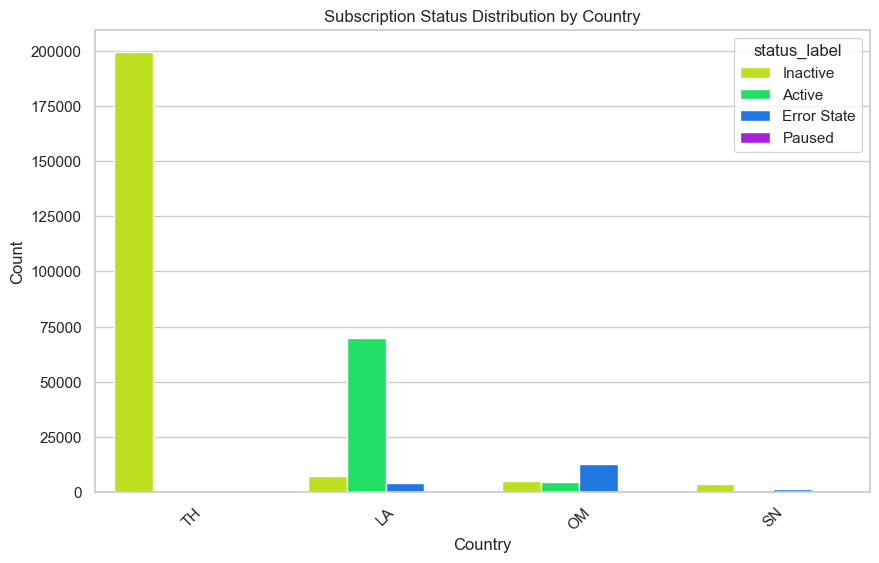

In [47]:
# Subscription Status Distribution by Country
df_sb.groupby(['country', 'operator', 'status_label']).size().reset_index(name='counts')

# Subscription Status Distribution by Country
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='country', hue='status_label', palette='hsv', order=df_sb['country'].value_counts().index)
plt.title('Subscription Status Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

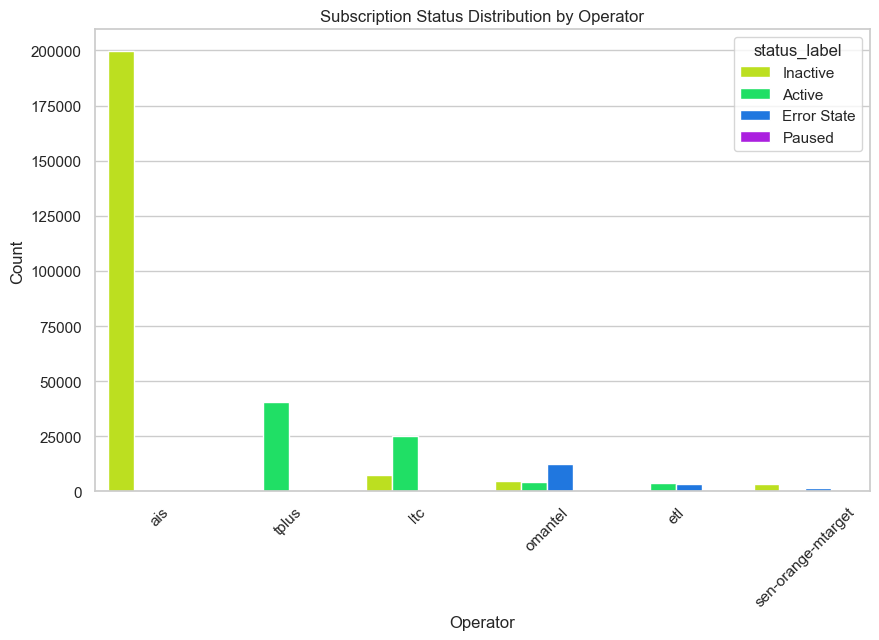

In [48]:

# Subscription Status Distribution by Operator
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='operator', hue='status_label', palette='hsv', order=df_sb['operator'].value_counts().index)
plt.title('Subscription Status Distribution by Operator')
plt.xlabel('Operator')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


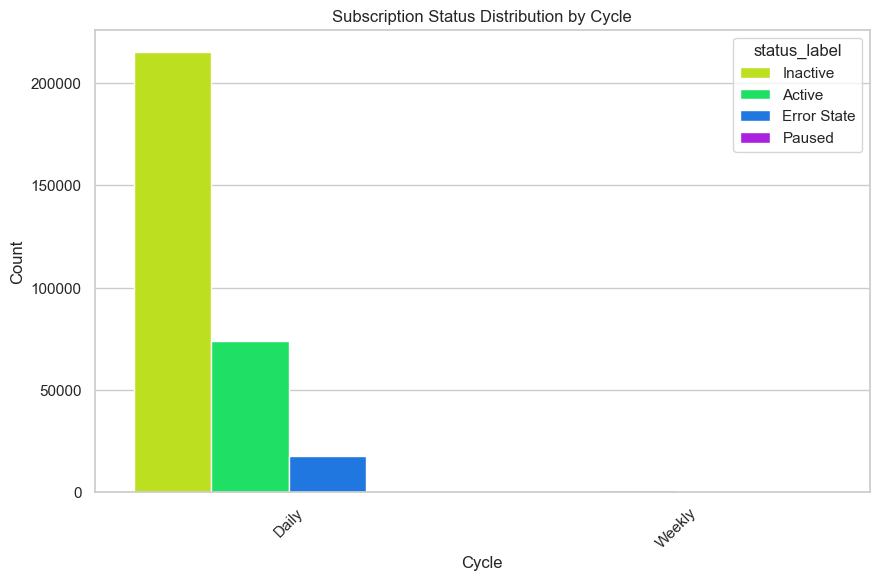

In [49]:
# Subscription Status Distribution by Cycle
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='cycle_label', hue='status_label', palette='hsv', order=df_sb['cycle_label'].value_counts().index)
plt.title('Subscription Status Distribution by Cycle')
plt.xlabel('Cycle')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


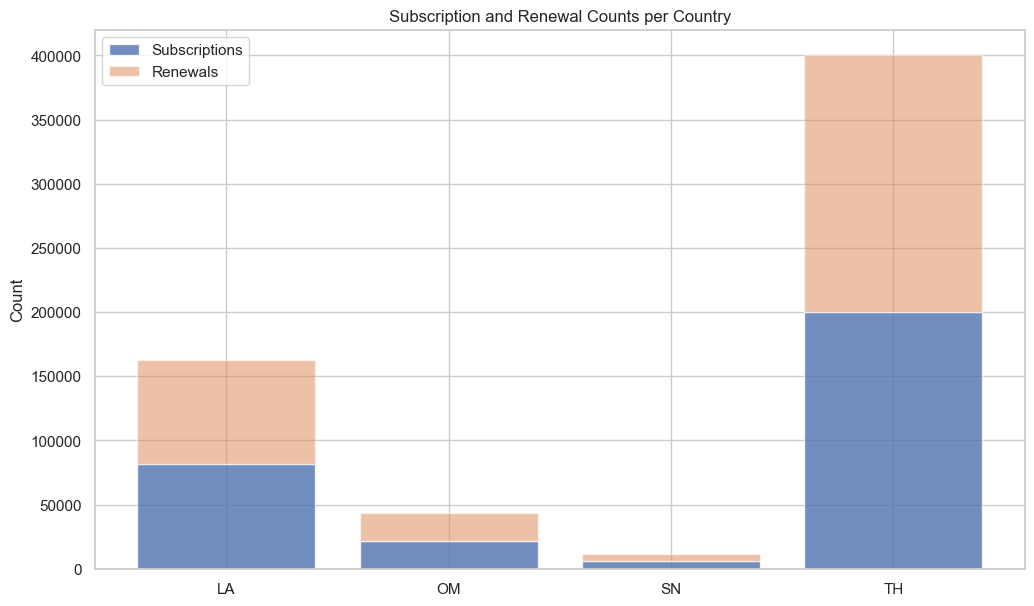

In [50]:
subscriptions_count = df_sb.groupby('country').size().reset_index(name='Subscription_Count')
renewals_count = df_sb.groupby('country').size().reset_index(name='Renewal_Count')
subs_renewals_per_country = pd.merge(subscriptions_count, renewals_count, on='country', how='outer').fillna(0)
plt.figure(figsize=(12, 7))
countries = subs_renewals_per_country['country']
subscription_counts = subs_renewals_per_country['Subscription_Count']
renewal_counts = subs_renewals_per_country['Renewal_Count']

plt.bar(countries, subscription_counts, align='center', alpha=0.8, label='Subscriptions')
plt.bar(countries, renewal_counts, align='center', alpha=0.5, label='Renewals', bottom=subscription_counts)

# plt.xticks(y_pos, countries)
plt.ylabel('Count')
plt.title('Subscription and Renewal Counts per Country')
plt.legend()

plt.show()



In [51]:
# df_sb['subs_date'].max()

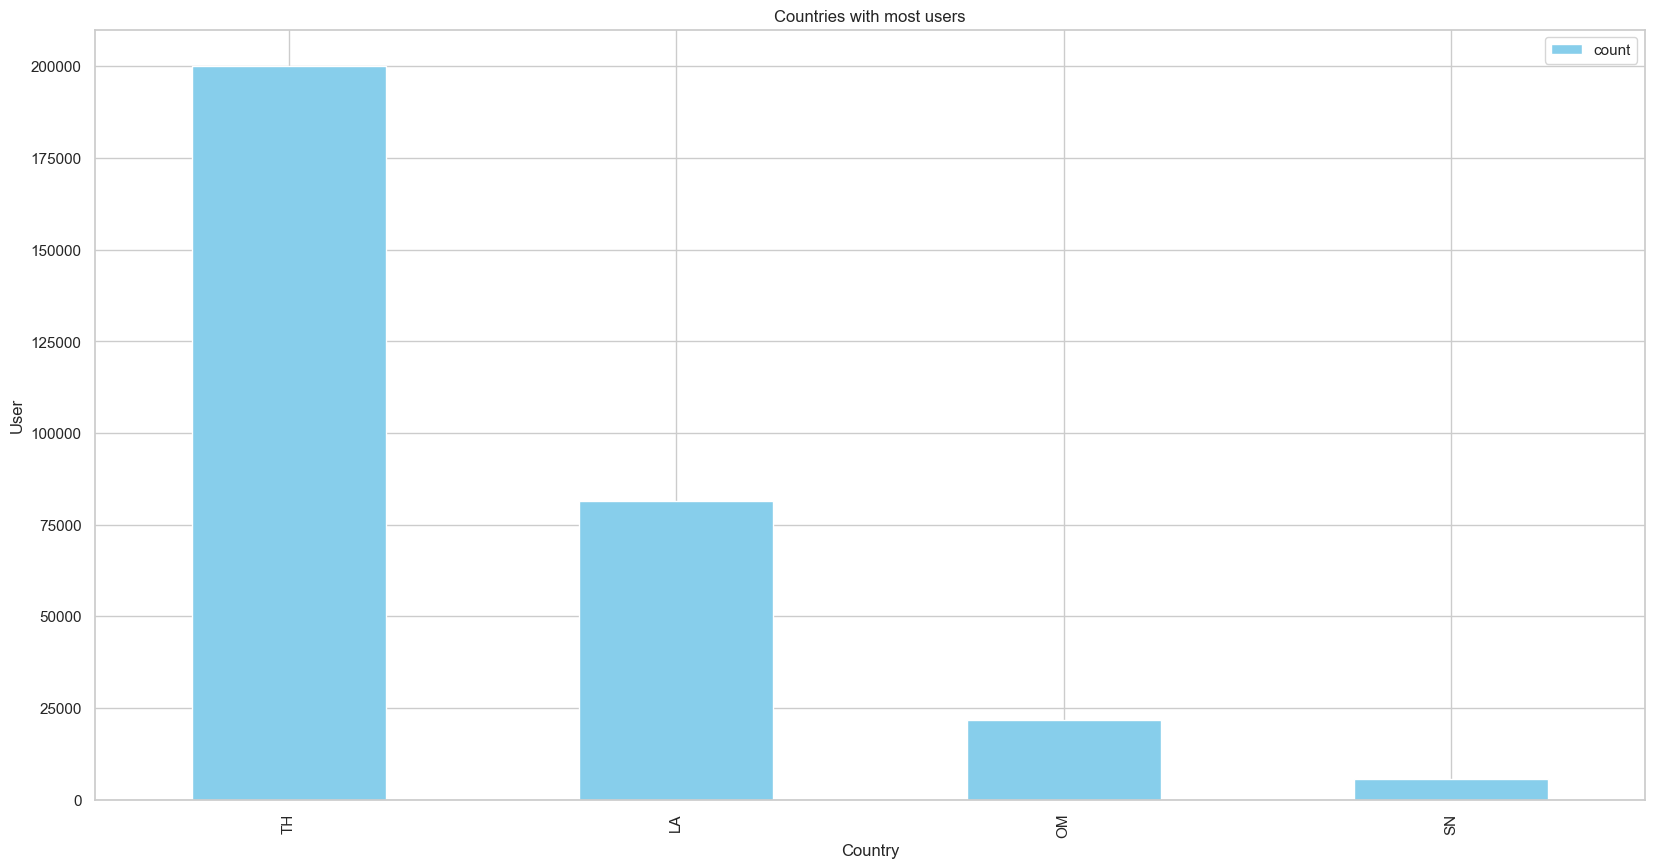

In [52]:
countries = df_sb['country'].value_counts()
topCountries = countries.head(20)
fig = plt.subplots(figsize=(20, 10))

topCountries.plot(kind='bar', color='skyblue')
plt.xlabel('Country')
plt.ylabel('User')
plt.title('Countries with most users')
plt.legend()
plt.show()



/var/folders/yg/gk3kh2hn45gb3sb4nslzjfy00000gn/T/ipykernel_5566/3810454579.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sb, x='adnet', palette='hsv', order=df_sb['adnet'].value_counts().index)


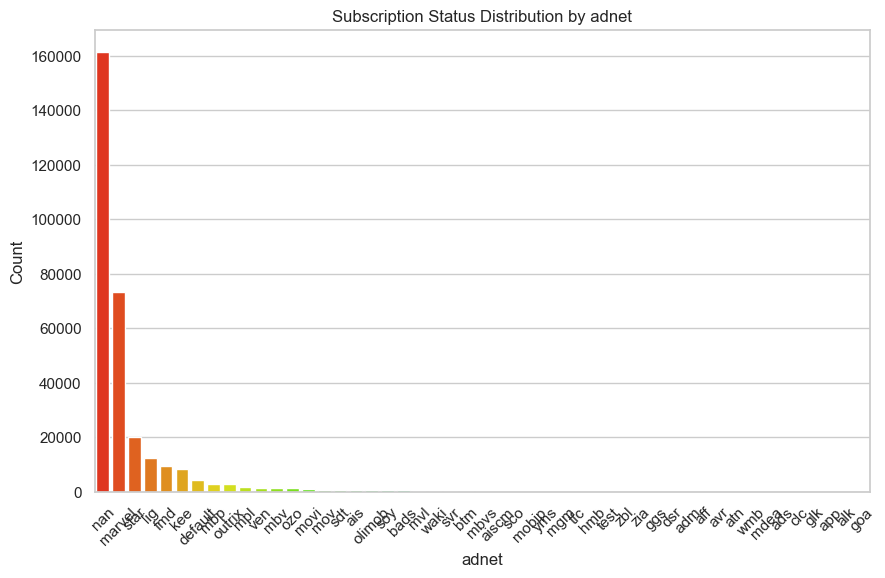

In [53]:

# revenue based on adnet
df_sb.groupby(['adnet']).size().reset_index(name='counts')

# revenue based on adnet 
#exclude nan
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='adnet', palette='hsv', order=df_sb['adnet'].value_counts().index)
plt.title('Subscription Status Distribution by adnet')
plt.xlabel('adnet')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Renewal, Retry, Notif, Unsubscribe, First_charge, 


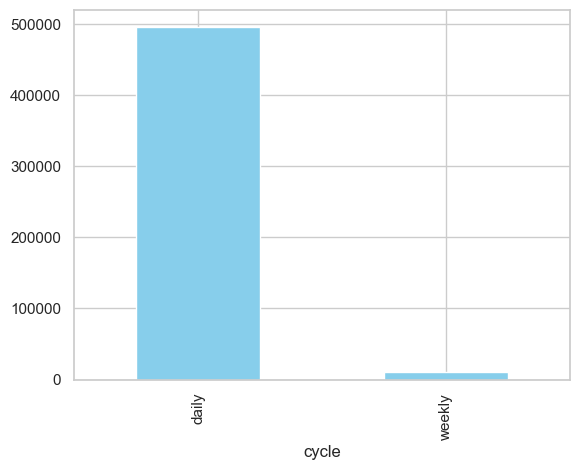

In [54]:
cycle_cnt = df_tr['cycle'].value_counts()
cycle_cnt.plot(kind='bar',color='skyblue')
plt.show()

## Keep this

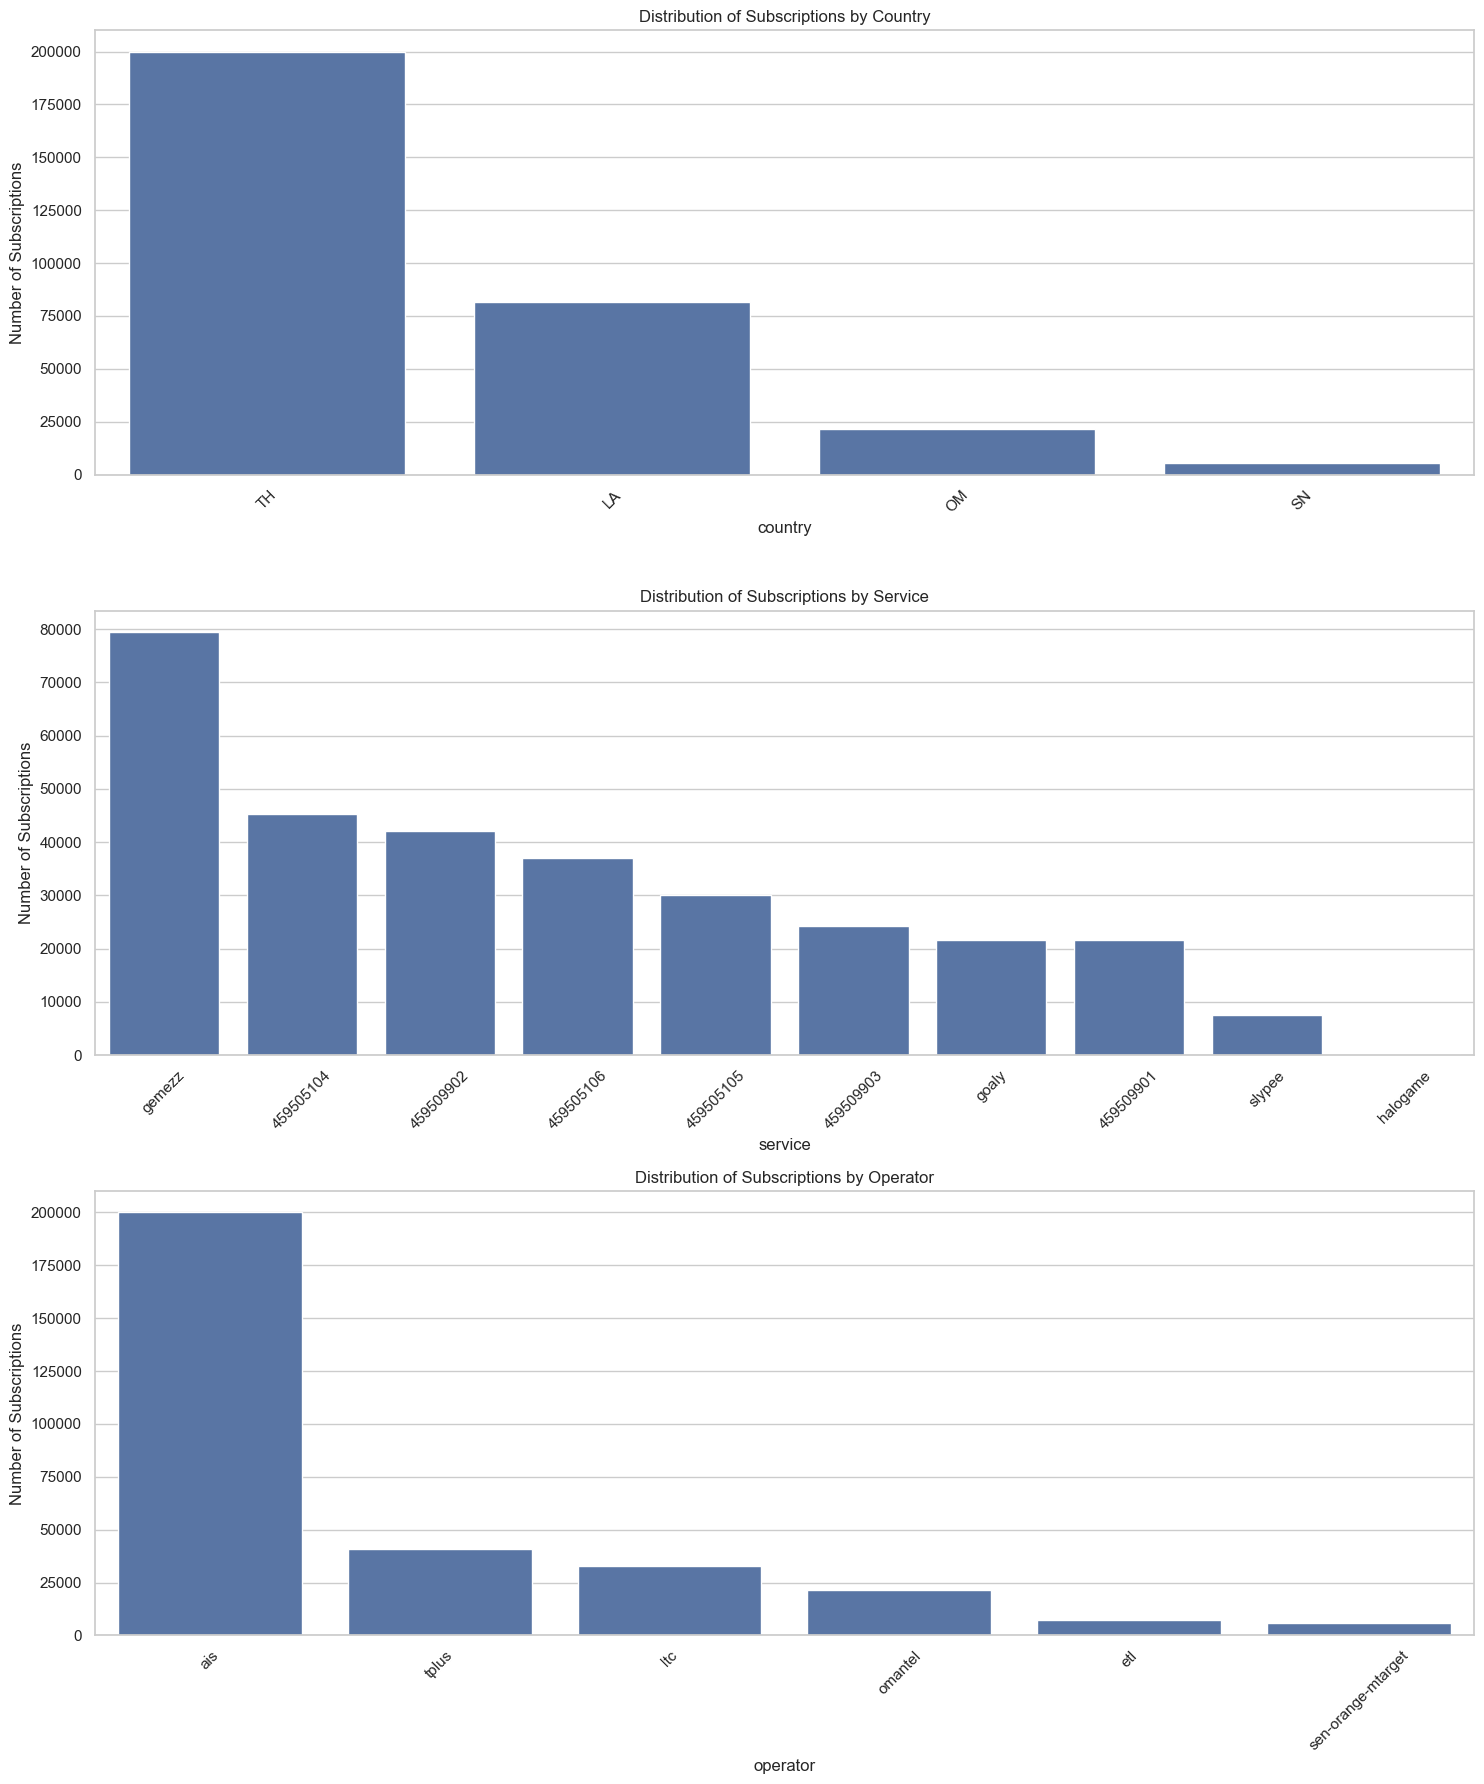

In [55]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))

#Country
sns.countplot(data=df_sb, x='country', ax=axes[0], order=df_sb['country'].value_counts().index)
axes[0].set_title('Distribution of Subscriptions by Country')
axes[0].set_ylabel('Number of Subscriptions')
axes[0].tick_params(axis='x', rotation=45)

#Service
sns.countplot(data=df_sb, x='service', ax=axes[1], order=df_sb['service'].value_counts().index)
axes[1].set_title('Distribution of Subscriptions by Service')
axes[1].set_ylabel('Number of Subscriptions')
axes[1].tick_params(axis='x', rotation=45)

#Operator
sns.countplot(data=df_sb, x='operator', ax=axes[2], order=df_sb['operator'].value_counts().index)
axes[2].set_title('Distribution of Subscriptions by Operator')
axes[2].set_ylabel('Number of Subscriptions')
axes[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## Keep this

In [57]:
#Convert revenue to float


dtype('O')

In [56]:
def convert_revenue(row):
    if row['country'] == 'SN':
        return float(row['revenue']) * 25.82
    elif row['country'] == 'TH':
        return float(row['revenue']) * 440
    elif row['country'] == 'OM':
        return float(row['revenue']) * 40171.27
    elif row['country'] == 'LA':
        return float(row['revenue']) * 0.75

df_sb['revenue in rupiah'] = df_sb.apply(convert_revenue, axis=1)
df_sb['revenue in rupiah']

ValueError: could not convert string to float: '150:00:00'

### Pre-Training Data (Data Cleaning Part 2)

##### Splitting the data and clean it using regex.

##### LabelEncoder

##### Impute, and Set Data Type to Object

##### Splitting the data

##### Imputing the splitted data, to make sure no NaN Values.

### Data Training

#### Data Model / Techniques

##### Decision Tree

Mean Squared Error: 0.0005980165833068537
R-squared (R2) Score: 0.9999999999997309


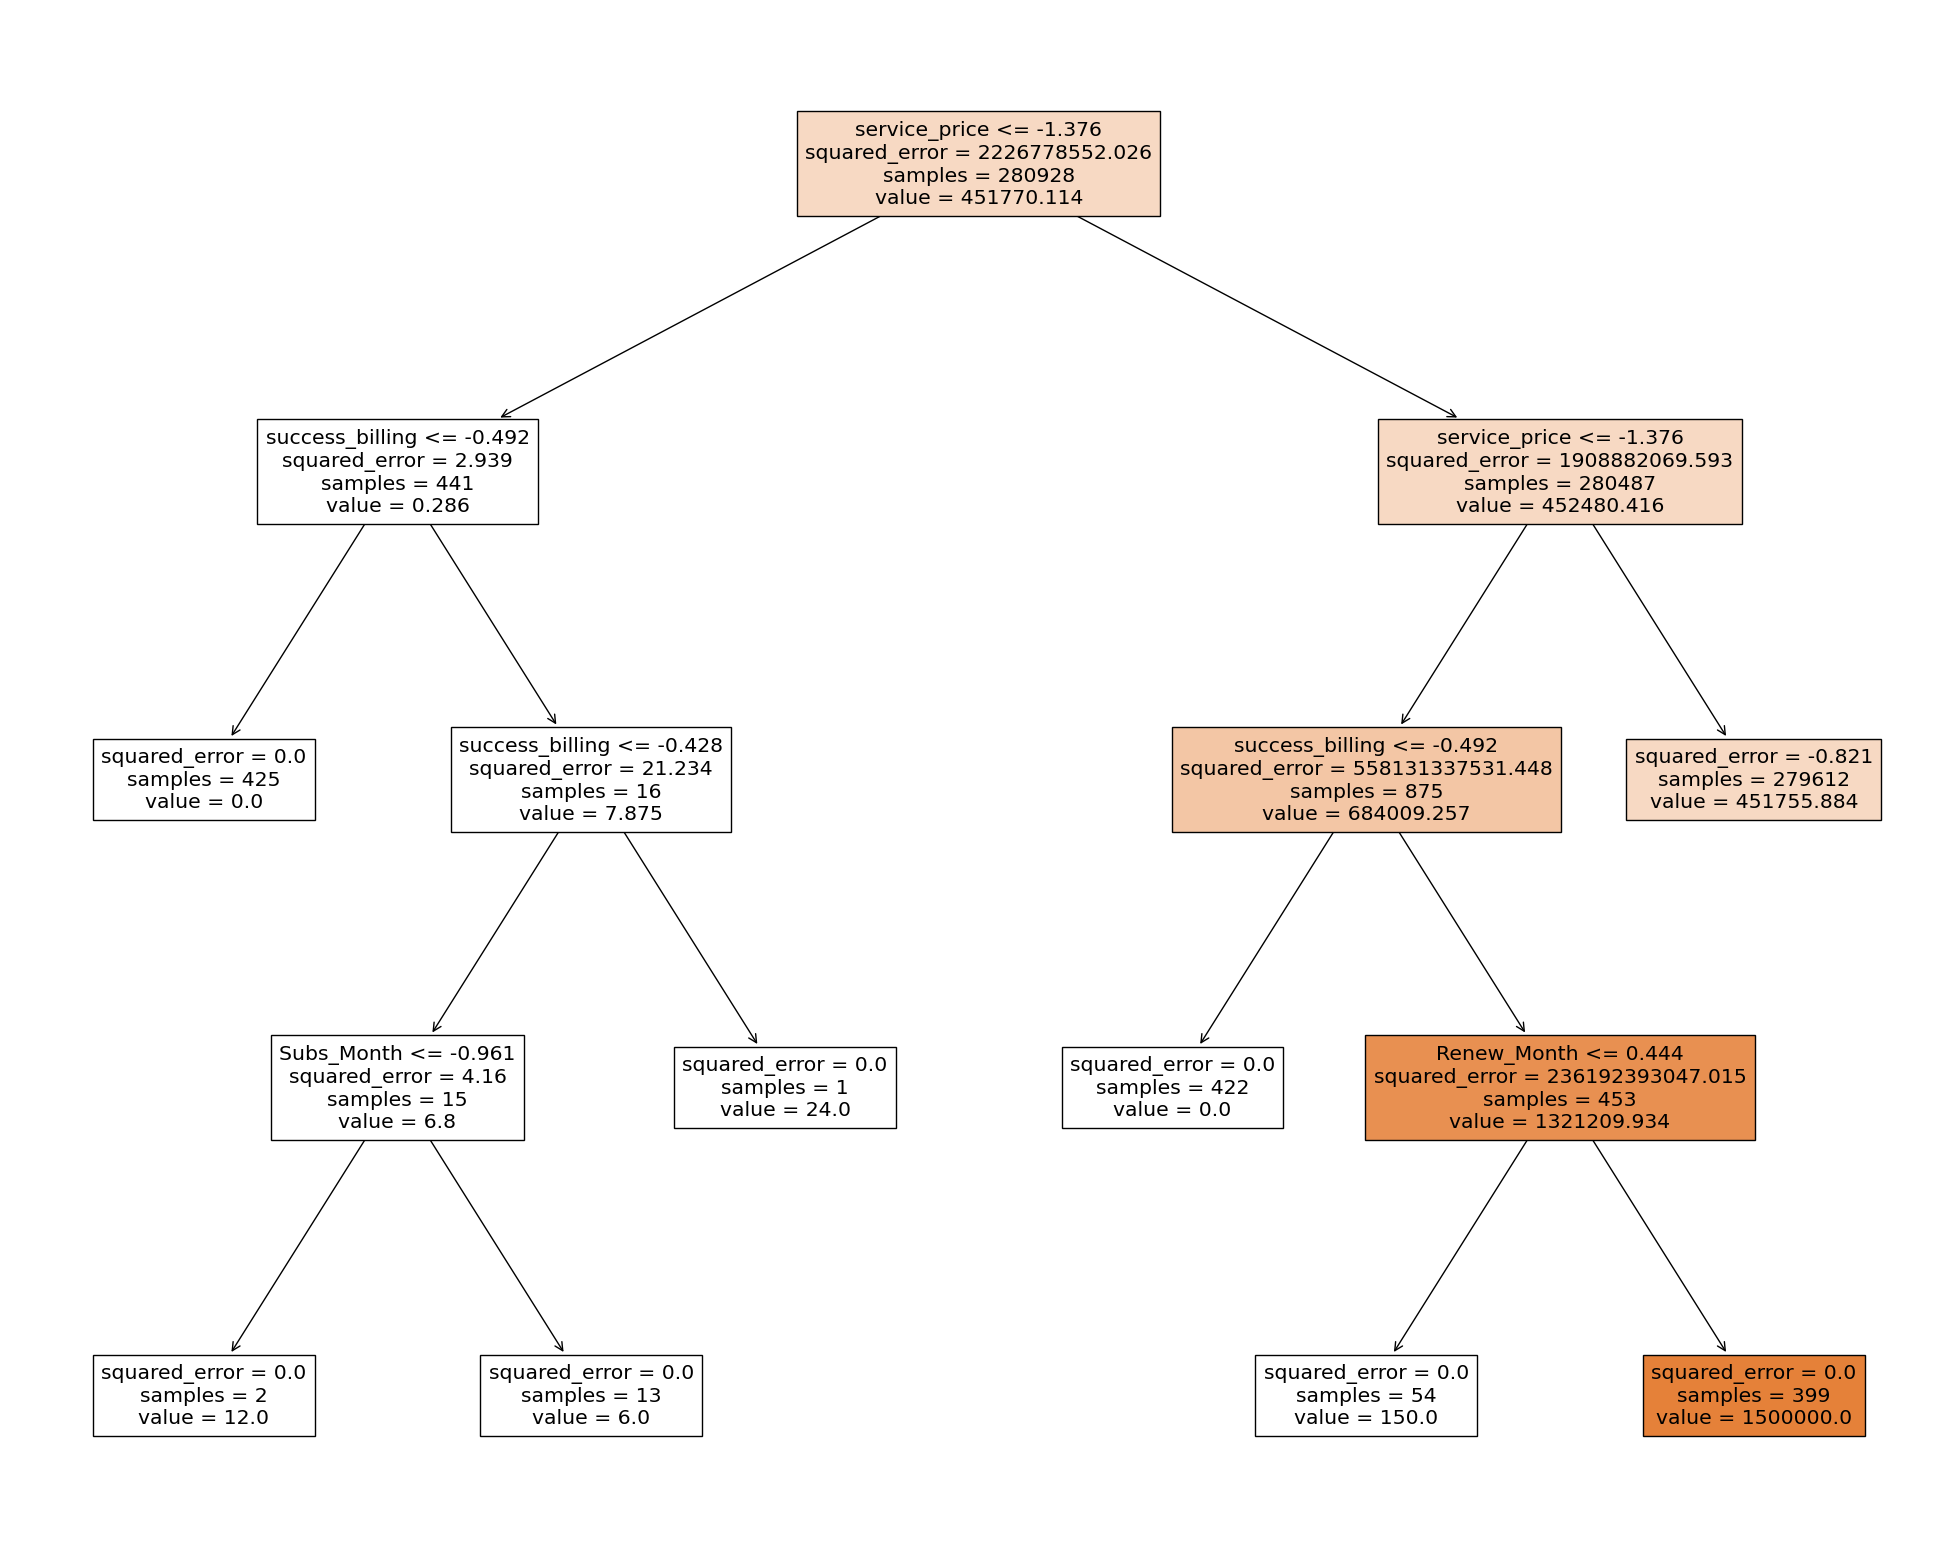

In [ ]:
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import render

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)


regresor_tree = DecisionTreeRegressor()
regresor_tree.fit(X_train,y_train)

# export_graphviz(regresor_tree, out_file ='tree.dot', filled=True, rounded=True)  

y_pred = regresor_tree.predict(X_test)
# render('dot', 'png', 'tree.dot')

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared (R2) Score:", r2)

fig = plt.figure()
_ = tree.plot_tree(regresor_tree,feature_names=X.columns, class_names=y, filled=True)

##Save Image (Optional)
# fig.savefig("decistion_tree.png")

##### Random Forest

Mean Squared Error (MSE):  6.105749390258793e-05
R-squared (R2) Score:  0.9999999999999726


[Text(0.5, 0.9, 'service_price <= -1.376\nsquared_error = 2264712388.948\nsamples = 177581\nvalue = 451822.418'),
 Text(0.2, 0.7, 'success_billing <= -0.492\nsquared_error = 2.702\nsamples = 266\nvalue = 0.26'),
 Text(0.1, 0.5, 'squared_error = 0.0\nsamples = 256\nvalue = 0.0'),
 Text(0.3, 0.5, 'success_billing <= -0.428\nsquared_error = 22.776\nsamples = 10\nvalue = 7.714'),
 Text(0.2, 0.3, 'Subs_Month <= -0.961\nsquared_error = 2.556\nsamples = 9\nvalue = 6.462'),
 Text(0.1, 0.1, 'squared_error = 0.0\nsamples = 1\nvalue = 12.0'),
 Text(0.3, 0.1, 'squared_error = 0.0\nsamples = 8\nvalue = 6.0'),
 Text(0.4, 0.3, 'squared_error = 0.0\nsamples = 1\nvalue = 24.0'),
 Text(0.8, 0.7, 'service_price <= -1.376\nsquared_error = 1964877020.98\nsamples = 177315\nvalue = 452492.471'),
 Text(0.7, 0.5, 'success_billing <= -0.492\nsquared_error = 557630173790.075\nsamples = 564\nvalue = 680319.358'),
 Text(0.6, 0.3, 'squared_error = 0.0\nsamples = 264\nvalue = 0.0'),
 Text(0.8, 0.3, 'Renew_Month <= 0

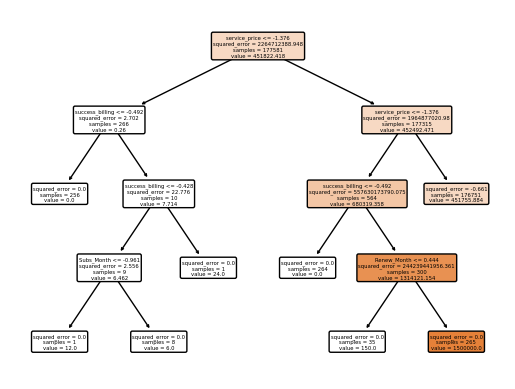

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree


Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error (MSE): ", mse)
print("R-squared (R2) Score: ", r2)


plot_tree(regressor.estimators_[0], filled=True, rounded=True, feature_names=X.columns)





##### SVR (Support Vector Regression)

In [ ]:
# from sklearn.svm import SVR

# # Cut the data to 1/4
# df_merge_25 = df_merge[0:(round(len(df_merge)/4))]
# X = df_merge_25[["Renew_Month", "cycle_tr_0", "service_price", "status", "Subs_Month", "profile_status", "attempt_charging", "success_billing"]]
# y = df_merge_25['revenue_subs']
# X2_train,X2_test,y2_train,y2_test = train_test_split(X, y, test_size=0.2, random_state=42)


# scaler = StandardScaler()
# X2_train = scaler.fit_transform(X_train)
# X2_test = scaler.transform(X_test)

# svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
# svr.fit(X_train, y_train)

# y2_pred = svr.predict(X2_test)

# mse = mean_squared_error(y2_test, y2_pred)
# r2 = r2_score(y2_test, y2_pred)

# print("Mean Squared Error: ", mse)
# print("R-squared (R2) Score: ", r2)


##### Linear Regression

mse: 2221607520.5934
r2: 0.00021310013153275076


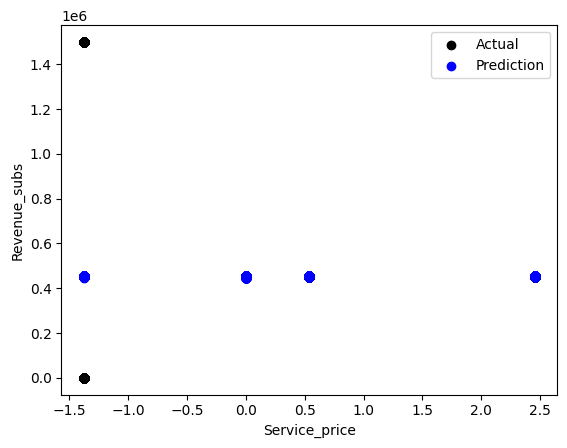

In [ ]:
linreg = LinearRegression()
linreg = linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("mse:", mse)
print("r2:", r2)

plt.scatter(X_test[:, 2], y_test, color='black', label='Actual')
plt.scatter(X_test[:, 2], y_pred, color='blue', label='Prediction')
plt.xlabel('Service_price')
plt.ylabel('Revenue_subs')
plt.legend()
plt.show()


##### K-Neighbors Regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

print("Mean Squared Error: ", mse)
print("R-squared (R2) Score: ", r2)

# plt.scatter(X_test[:, 2], y_test, color='black', label='Actual')
# plt.scatter(X_test[:, 2], y_pred, color='blue', label='Prediction')
# plt.xlabel('Service_price')
# plt.ylabel('Revenue_subs')
# plt.legend()
# plt.show()

# residuals = y_test - y_pred

# plt.scatter(y_test, y_pred, color='blue')
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)  # Diagonal line for perfect predictions
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Values for KNN Regression')
# plt.show()

# plt.scatter(y_test, residuals, color='green')
# plt.axhline(y=0, color='red', linestyle='--', linewidth=2)  # Line at y=0 for zero residuals
# plt.xlabel('Actual Values')
# plt.ylabel('Residuals')
# plt.title('Residual Plot for KNN Regression')
# plt.show()

KeyboardInterrupt: 